# Initialize the accelerator

In [1]:
from finn_examples import models
print(list(filter(lambda x: "mnist" in x, dir(models))))

['tfc_w1a1_mnist']


In [2]:
accel = models.tfc_w1a1_mnist()

In [3]:
print("Expected input shape and datatype: %s %s" % (str(accel.ishape_normal), str(accel.idt)))
print("Expected output shape and datatype: %s %s" % (str(accel.oshape_normal), str(accel.odt)))

Expected input shape and datatype: (1, 784) DataType.UINT8
Expected output shape and datatype: (1, 1) DataType.UINT8


# Load the MNIST dataset

Use the `dataset_loading` package to get easy Python access to MNIST dataset:

In [4]:
from dataset_loading import mnist
trainx, trainy, testx, testy, valx, valy = mnist.load_mnist_data("/tmp", download=True, one_hot=False)

Looking for Train Imgs
Tar File found in data_dir. Not Downloading again
Looking for Train Labels
Tar File found in data_dir. Not Downloading again
Looking for Test Imgs
Tar File found in data_dir. Not Downloading again
Looking for Test Labels
Tar File found in data_dir. Not Downloading again


In [5]:
testx.shape

(10000, 28, 28, 1)

# Classify a single image

In [6]:
test_single_x = testx[0].reshape(28, 28)
test_single_y = testy[0]

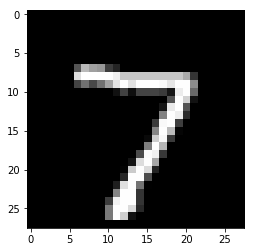

In [15]:
from matplotlib import pyplot as plt

plt.imshow(test_single_x, cmap='gray')
plt.show()

In [16]:
print("Expected class is %d" % test_single_y)

Expected class is 7


In [17]:
accel_in = test_single_x.reshape(accel.ishape_normal)
print("Input buffer shape is %s and datatype is %s" % (str(accel_in.shape), str(accel_in.dtype)))

Input buffer shape is (1, 784) and datatype is uint8


In [18]:
accel_out = accel.execute(accel_in)

In [19]:
print("Returned class is %d" % accel_out)

Returned class is 7


In [20]:
%%timeit
accel_out = accel.execute(accel_in)

1 loop, best of 3: 460 ms per loop


# Go faster: skip unneeded data packing/unpacking

FINN-generated accelerators pack few-bit values next to each other to save on memory and bandwidth. For instance, four 2-bit values can be packed into an 8-bit word.

The `accel.execute()` function takes a regular (unpacked) numpy array and performs the appropriate packing for the accelerator at hand, and performs unpacking on the result before returning it. However, in some cases it's not necessary to do any data packing and unpacking:

In [51]:
print("Input datatype is %s, normal shape is %s, folded shape is %s, packed shape is %s" % (accel.idt, accel.ishape_normal, accel.ishape_folded, accel.ishape_packed))
print("Output datatype is %s, normal shape is %s, folded shape is %s, packed shape is %s" % (accel.odt, accel.oshape_normal, accel.oshape_folded, accel.oshape_packed))

Input datatype is DataType.UINT8, normal shape is (1000, 784), folded shape is (1000, 1, 784), packed shape is (1000, 1, 784)
Output datatype is DataType.UINT8, normal shape is (1000, 1), folded shape is (1000, 1, 1), packed shape is (1000, 1, 1)


Since this accelerator uses uint8 inputs, the normal, folded and packed shapes are all the same (just with an extra dummy dimension), so we can skip all software preprocessing to pack the input data, writing the image straight into the accelerator buffers and executing it straight away.

In [22]:
# prepare input/output buffer
accel_in_reshaped = accel_in.reshape(accel.ishape_packed)
import numpy as np
out_buf = np.empty_like(accel.obuf_packed_device)

In [23]:
accel.copy_input_data_to_device(accel_in_reshaped)
accel.execute_on_buffers()
accel.copy_output_data_from_device(out_buf)

In [24]:
print(out_buf)

[[[7]]]


Let's see how much faster we got:

In [28]:
%%timeit -n 10
accel.copy_input_data_to_device(accel_in_reshaped)

10 loops, best of 3: 136 µs per loop


In [29]:
%%timeit -n 10
accel.execute_on_buffers()

10 loops, best of 3: 215 µs per loop


In [30]:
%%timeit -n 10
accel.copy_output_data_from_device(out_buf)

10 loops, best of 3: 123 µs per loop


# Validate accuracy on entire MNIST test set

In [31]:
batch_size = 1000
total = testx.shape[0]
accel.batch_size = batch_size
n_batches = int(total / batch_size)

batch_imgs = testx.reshape(n_batches, batch_size, -1)
batch_labels = testy.reshape(n_batches, batch_size)
obuf_normal = np.empty_like(accel.obuf_packed_device)
print("Ready to run validation, test images tensor has shape %s" % str(batch_imgs.shape))
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_packed), str(accel.oshape_packed)) )

Ready to run validation, test images tensor has shape (10, 1000, 784)
Accelerator buffer shapes are (1000, 1, 784) for input, (1000, 1, 1) for output


In [32]:
ok = 0
nok = 0
for i in range(n_batches):
    ibuf_normal = batch_imgs[i].reshape(accel.ishape_packed)
    exp = batch_labels[i]
    accel.copy_input_data_to_device(ibuf_normal)
    accel.execute_on_buffers()
    accel.copy_output_data_from_device(obuf_normal)
    ret = np.bincount(obuf_normal.flatten() == exp.flatten())
    nok += ret[0]
    ok += ret[1]
    print("batch %d / %d : total OK %d NOK %d" % (i, n_batches, ok, nok))

batch 0 / 10 : total OK 913 NOK 87
batch 1 / 10 : total OK 1800 NOK 200
batch 2 / 10 : total OK 2714 NOK 286
batch 3 / 10 : total OK 3619 NOK 381
batch 4 / 10 : total OK 4535 NOK 465
batch 5 / 10 : total OK 5488 NOK 512
batch 6 / 10 : total OK 6438 NOK 562
batch 7 / 10 : total OK 7399 NOK 601
batch 8 / 10 : total OK 8371 NOK 629
batch 9 / 10 : total OK 9296 NOK 704


In [33]:
acc = 100.0 * ok / (total)
print("Final accuracy: {}%".format(acc))

Final accuracy: 92.96%


In [36]:
def run_validation():
    for i in range(n_batches):
        ibuf_normal = batch_imgs[i].reshape(accel.ishape_packed)
        exp = batch_labels[i]
        accel.copy_input_data_to_device(ibuf_normal)
        accel.execute_on_buffers()
        accel.copy_output_data_from_device(obuf_normal)

In [43]:
full_validation_time = %timeit -n 5 -o run_validation()

5 loops, best of 3: 60.1 ms per loop


In [48]:
print("%f images per second including data movement" % (total / float(full_validation_time.best)))

166443.297542 images per second including data movement


In [45]:
accel_time = %timeit -n {n_batches} -o accel.execute_on_buffers()

10 loops, best of 3: 1.22 ms per loop


In [50]:
print("%f images per second excluding data movement" % (total / float(accel_time.best)))

8195882.239336 images per second excluding data movement
